<b> This notebook includes EDA and feature engineering and aimed to predict TripAdvisor Rating of the given restaurants. The goal is to predict what rating a restaurant has on the basis of the given data, which includes location,  reviews, type of kitchen, etc.

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import warnings
warnings.simplefilter("ignore")
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import colorlover as cl

import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [41]:
train_data = pd.read_csv('main_task.csv')
train_data.shape

(40000, 10)

In [42]:
train_data.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


<b>`Rating` is our target variable

In [43]:
test_data = pd.read_csv('kaggle_task.csv')
test_data.shape

(10000, 10)

<b>Merging test and train datasets in order to optimize data cleaning 

In [44]:
test_data['Rating'] = 0
data = train_data.append(test_data, sort=False).reset_index(drop=True)
data.shape

(50000, 11)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Rating               50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
Name                 10000 non-null object
dtypes: float64(3), object(8)
memory usage: 4.2+ MB


<b> Investigating ranking of the restaurants in the cities

In [46]:
import plotly.io as pio
pio.renderers.default = "svg"

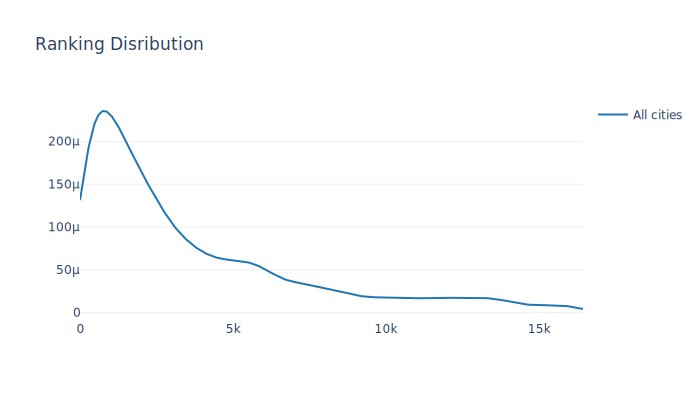

In [47]:
import plotly.figure_factory as ff
group_labels = ['All cities']

fig = ff.create_distplot([data['Ranking'].to_list()], group_labels, show_hist=False, show_rug=False)
fig.update_layout(title_text='Ranking Disribution',
                  width=700,
                  height=400,
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=10, zeroline=False)
                 )
pio.show(fig, width=700, height=400)

# How it is skewed?

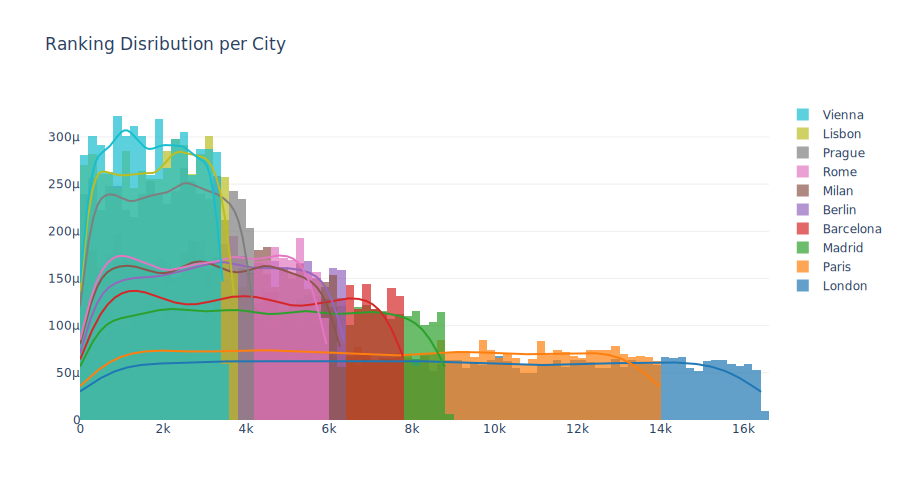

In [48]:
import plotly.figure_factory as ff

hist_data=[]
group_labels=[]
for i in (data['City'].value_counts())[0:10].index:
    x = data[data['City'] ==i]['Ranking'].to_list()
    hist_data.append(x)
    group_labels.append(i)

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, show_curve=True, show_rug=False, bin_size=200)
fig.update_layout(title_text='Ranking Disribution per City',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=10, zeroline=False)
                 )
pio.show(fig, width=900, height=500)

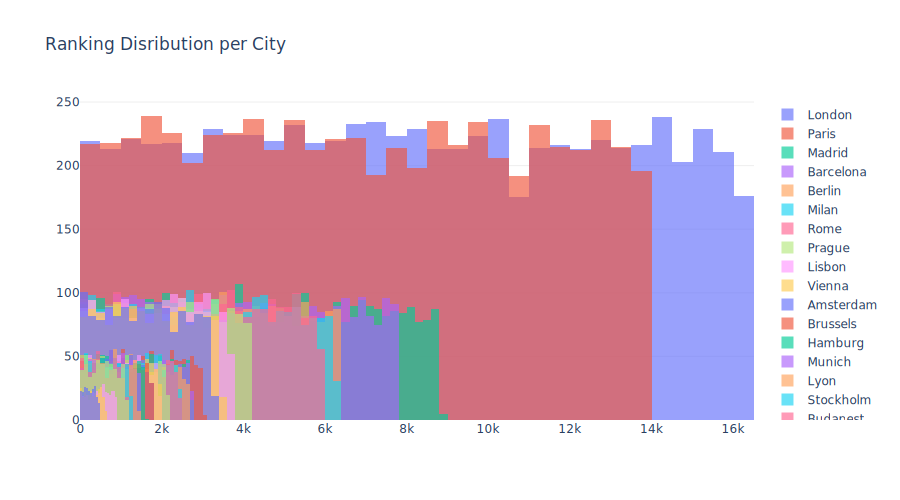

In [49]:
fig = go.Figure()
for i in (data['City'].value_counts())[0:].index:
    x=data[data['City'] ==i]['Ranking'].to_list()
    fig.add_trace(go.Histogram(x=x, name=i))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.65)
fig.update_layout(title_text='Ranking Disribution per City',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=10, zeroline=False)
                 )
pio.show(fig, width=900, height=500)

### Number of Restaurants in the City

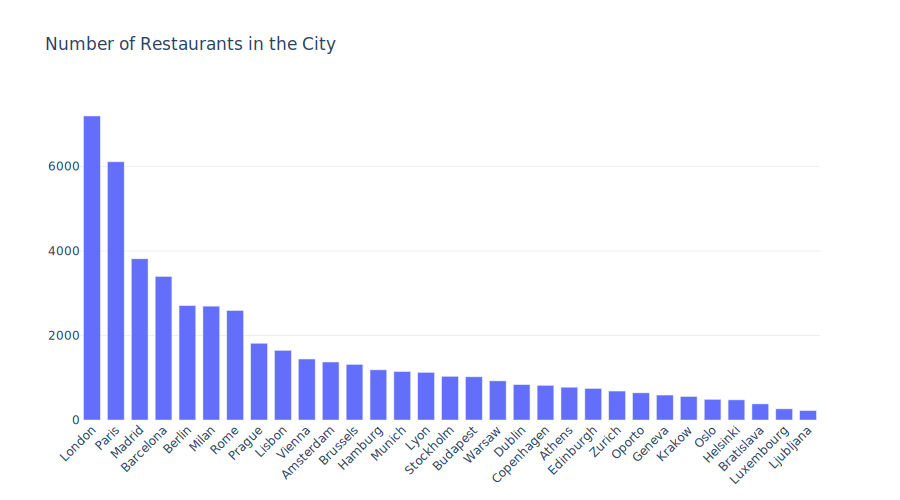

In [50]:
bar_data = data.groupby(['City'])['City'].count().sort_values(ascending=False)
fig = go.Figure([go.Bar(x=bar_data.index, y=bar_data, width=0.7)])
fig.update_layout(title_text='Number of Restaurants in the City',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(tickangle=-45),
                  yaxis=dict(gridcolor='#EEEEEE', nticks=7),
                  bargap=0.05,
                 )
pio.show(fig, width=900, height=500)

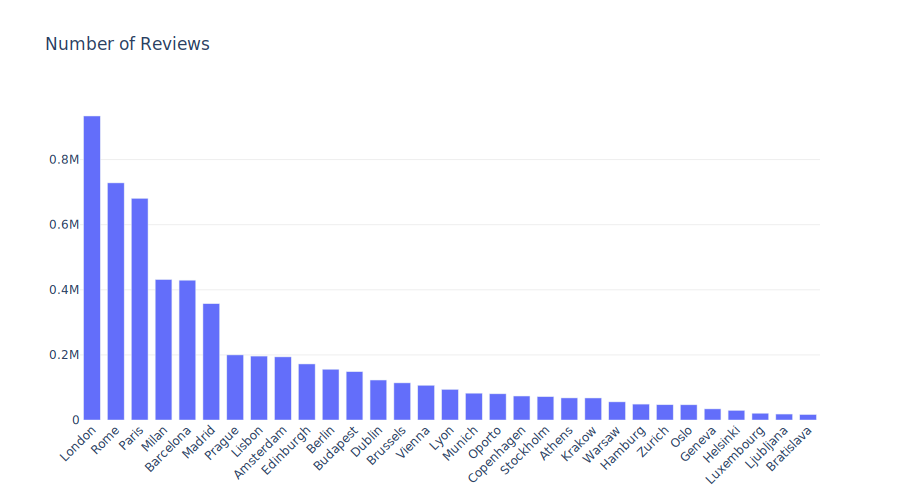

In [51]:
bar_data = data.groupby(['City'])['Number of Reviews'].sum().sort_values(ascending=False)
fig = go.Figure([go.Bar(x=bar_data.index, y=bar_data, width=0.7)])
fig.update_layout(title_text='Number of Reviews',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(tickangle=-45),
                  yaxis=dict(gridcolor='#EEEEEE', nticks=7),
                  bargap=0.05,
                 )
pio.show(fig, width=900, height=500)

### How many restaurants with the given rating?

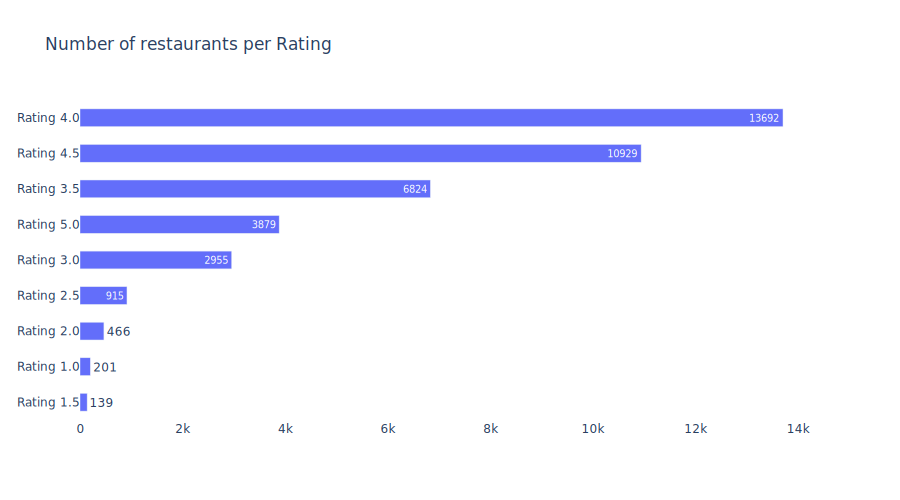

In [52]:
bar_data = train_data['Rating'].astype(str).value_counts(ascending=True)
fig = go.Figure([go.Bar(y='Rating ' + bar_data.index, 
                        x=bar_data, 
                        width=0.5,
                        text=bar_data,
                        textposition='auto',
                        orientation='h'
                       )])

fig.update_layout(title_text='Number of restaurants per Rating',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                 )
pio.show(fig, width=900, height=500)

### Number of Reviews vs. Ranking

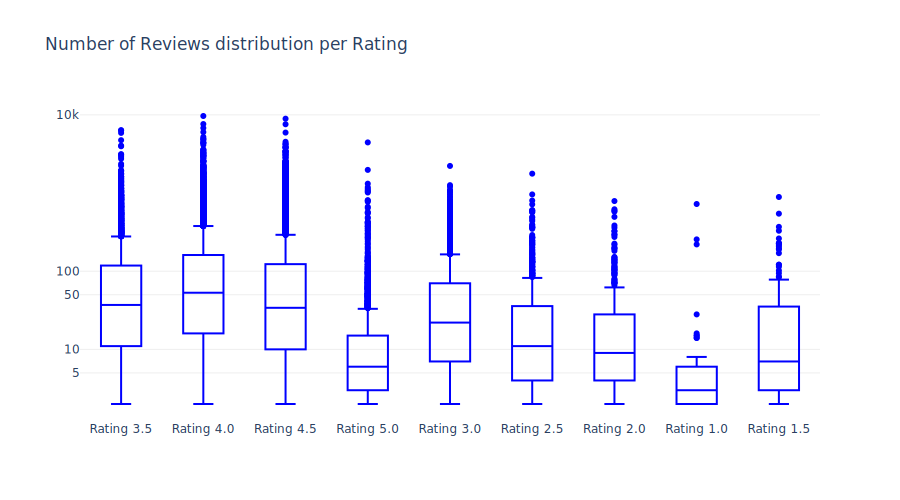

In [53]:
fig = go.Figure()
y = train_data['Number of Reviews']
x = train_data['Rating'].astype(str)

fig.add_trace(go.Box(y=y, 
                     x='Rating ' + x,
                     fillcolor='rgba(0,0,0,0)', 
                     line = dict(color = 'blue'),
                    ))
fig.update_layout(title_text='Number of Reviews distribution per Rating',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=5)
                 )
fig.update_yaxes(tickvals=[0, 5, 10, 50, 100, 10000])
fig.update_yaxes(type="log")

pio.show(fig, width=900, height=500)

<b>Ranking distribution per Rating

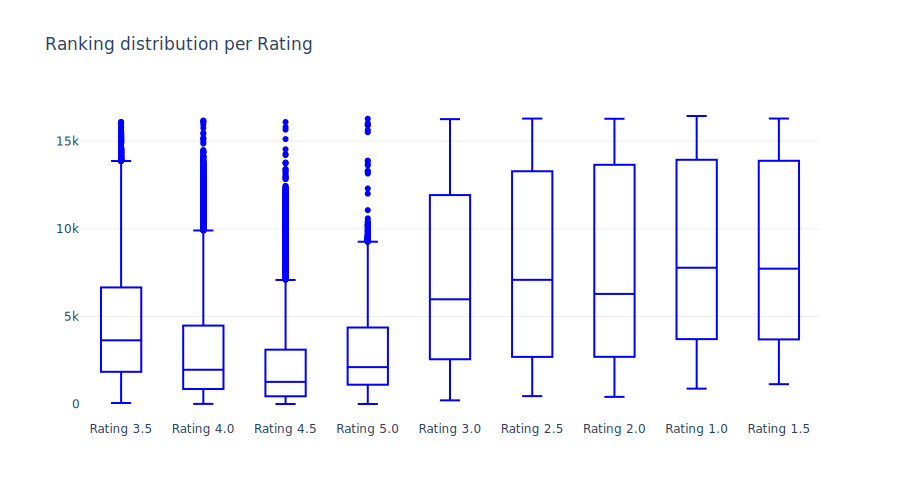

In [54]:
fig = go.Figure()
y = train_data['Ranking']
x = train_data['Rating'].astype(str)

fig.add_trace(go.Box(y=y, 
                     x='Rating ' + x,
                     fillcolor='rgba(0,0,0,0)', 
                     line = dict(color = 'blue'),
                    ))
fig.update_layout(title_text='Ranking distribution per Rating',
                  width=900,
                  height=500,
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=5)
                 )
pio.show(fig, width=900, height=500)

<b>Ranking distribution per Rating/City

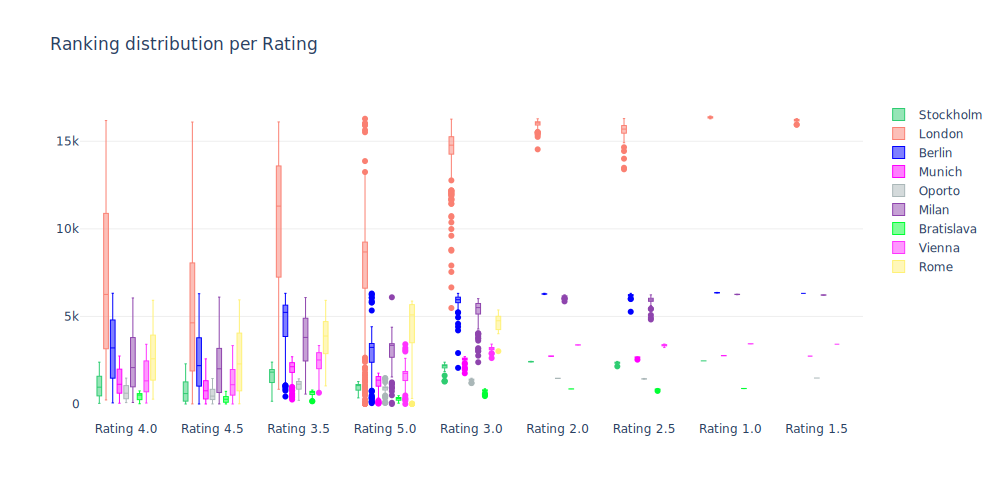

In [55]:
fig = go.Figure()
#color=cl.scales['5']['qual']['Set2']+cl.scales['5']['qual']['Set3']
color = ['#2ECC71','#FA8072','#0000FF','#FF00FF','#AAB7B8','#8E44AD','#00FF33','#FF33FF','#FFF176','#CE93D8'] 
for i,j in enumerate(train_data['City'].unique()[1:10]):
    y = train_data[train_data['City'] == j]['Ranking']
    x = train_data[train_data['City'] == j]['Rating'].astype(str)
    fig.add_trace(go.Box(y=y, 
                         x='Rating ' + x,
                         name=j,
                         line = dict(color = color[i], width=1),
                         #boxpoints=False
                        ))

fig.update_layout(title_text='Ranking distribution per Rating',
                  width=1000,
                  height=500,
                  boxmode='group',
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=5)
                 )
pio.show(fig, width=1000, height=500)

<b>Ranking distribution per City/Rating

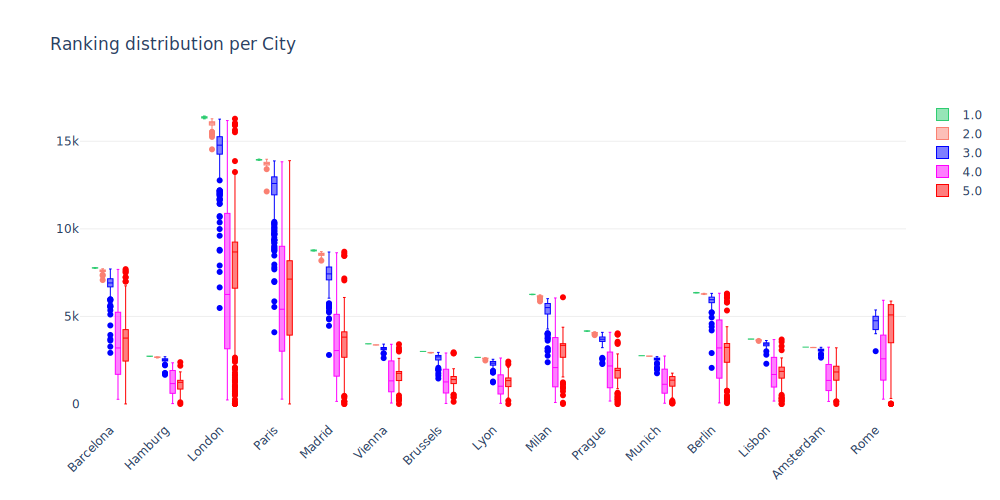

In [56]:
fig = go.Figure()
color = ['#2ECC71','#FA8072','#0000FF','#FF00FF','red','#8E44AD','#00FF33'] 
for i,j in enumerate([1.0,2.0,3.0,4.0,5.0]):
    y = train_data[(train_data['Rating'] == j) & (train_data['City'].isin(train_data['City'].value_counts()[0:15].index))]['Ranking']
    x = train_data[(train_data['Rating'] == j) & (train_data['City'].isin(train_data['City'].value_counts()[0:15].index))]['City']
    fig.add_trace(go.Box(y=y, 
                         x=x,
                         name=j,
                         line = dict(color = color[i], width=1),
                        ))
fig.update_layout(title_text='Ranking distribution per City',
                  width=1000,
                  height=500,
                  boxmode='group',
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis=dict(gridcolor='#EEEEEE', nticks=5),
                  xaxis=dict(tickangle=-45)
                 )
pio.show(fig, width=1000, height=500)

# Outliers

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=4, cols=4, vertical_spacing = 0.06,
                    subplot_titles=(train_data['City'].value_counts()[0:16].index))
for i,j in enumerate(train_data['City'].value_counts()[0:16].index):
    col=i%4+1
    row=i//4+1
    fig.add_trace(go.Scatter(x=train_data[train_data['City']==j]['Ranking'],
                             y=train_data[train_data['City']==j]['Number of Reviews'],
                             mode='markers',
                             marker=dict(color='rgba(0,0,0,0)',
                                         line_width=0.9,
                                         line_color = train_data[train_data['City']==j]['Rating'],
                                         line_colorscale='rainbow',
                                         maxdisplayed=4000
                                        ),
                             text=train_data[train_data['City']==j]['Rating']),
                  row=row,
                  col=col
                 ) 
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

fig.update_layout(title='Rating outliers',
                  width=1000,
                  height=1000,
                  plot_bgcolor='rgba(0,0,0,0)',
                  showlegend=False
                 )
fig.update_xaxes(title_text="Ranking", row=4, col=2)
fig.update_yaxes(title_text="Number of Reviews", row=2, col=1)
pio.show(fig, width=1000, height=1000)

# Data Preprocessing

<b> Dropping irrelevant data

In [ ]:
data.drop(['URL_TA',  'Restaurant_id', 'ID_TA',  'Name'], axis=1, inplace=True)
data.shape

In [ ]:
data.dtypes

# Feature Engineering

**First/Last Review**

In [ ]:
import time
import datetime
#extracting date from review columns
data['First Review'] = data['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?=\'\]))')
data['Last Review'] = data['Reviews'].str.extract(r'(\d{2}\/\d{2}\/\d{4}(?!\'\]))')

#converting to datetime
data['First Review'] = pd.to_datetime(data['First Review'], format = "%m/%d/%Y")
data['Last Review'] = pd.to_datetime(data['Last Review'], format = "%m/%d/%Y")
data['First Review'] = data['First Review'].fillna(0)
data['Last Review'] = data['Last Review'].fillna(0)

#was a review given on the weekend?
data['Last Review Weekend'] = data['Last Review'].apply(lambda x: x.dayofweek if x!=0 else x)
data['First Review Weekend'] = data['First Review'].apply(lambda x: x.dayofweek if x!=0 else x)
data['Last Review Weekend'] = data['Last Review Weekend'].apply(lambda x: 1 if x >= 5 else 0)
data['First Review Weekend'] = data['First Review Weekend'].apply(lambda x: 1 if x >= 5 else 0)

#converting to UNIX time
data['Last Review'] = data['Last Review'].apply(lambda x: time.mktime(x.timetuple()) if x!=0 else 0)
data['First Review'] = data['First Review'].apply(lambda x: time.mktime(x.timetuple()) if x!=0 else 0)

#calculating time difference between first and last review
data['Days from First to Last Review'] = data['Last Review'] - data['First Review']
data['Days from First to Last Review'] = data['Days from First to Last Review'].apply(lambda x: -x if x<0 else x)

#time difference between first and last review in days
days = np.array(data['Days from First to Last Review'])
days = days/24/60/60
data['Days from First to Last Review'] = days

#converting UNIX time to days
data['Last Review'] = pd.to_numeric(data['Last Review'])/24/60/60
data['First Review'] = pd.to_numeric(data['First Review'])/24/60/60

<b>Is the restaurant located in the capital?

In [ ]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna', 'Rome', 'Madrid','Dublin', 'Brussels', 
            'Warsaw', 'Budapest', 'Copenhagen','Amsterdam', 'Lisbon', 'Prague', 'Oslo','Helsinki', 'Edinburgh', 
            'Ljubljana', 'Athens','Luxembourg']
data['Capital'] = data['City'] 
data['Capital'] = data['Capital'].apply(lambda x: 1 if x in capitals else 0)

**Is a given review positive?**

In [ ]:
data['Reviews'] = data['Reviews'].astype(str)
data['Reviews'] = data['Reviews'].str.split(pat = "],", expand=True)[0].str.replace("'","")
data['Reviews'] = data['Reviews'].str.replace(r'(\[\[)','').str.replace(',','')

positive = ['unique', 'great', 'good', 'heavenly', 'brilliant', 'amazing', 'tasty', 'delicious', 'healthy', 'perfect', 
            'nice', 'wonderful', 'delight', 'enjoy', 'awesome', 'super', 'charm', 'excellent', 'lovely', ':)', 
            'friendly', 'yum', 'beautiful','fresh', 'fantastic', 'talent', 'grand', 'relax', 'best', 'modern', 'cosy']
negative = ['poor', 'terrible', 'disappoint', 'horrible', 'overpriced', 'strange', 'refused', 'unappealing', 'worst', 
            'boring', 'racism','bad', 'expensive','appalling', ':(', 'amateur', 'dirty', 'rude', 'wretched', 'amiss']

data['Positive Feedback'] = data['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in positive) else 0)
data['Negative Feedback'] = data['Reviews'].apply(lambda x: 1 if any(word in x.lower() for word in negative) else 0)

<b> Number of Cusine Styles in the restaurant?

In [ ]:
data['Cuisine Style'] = data['Cuisine Style'].astype(str)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x[1:-1] if x != "nan" else x)
data['Number of Cusine Styles'] = data['Cuisine Style'].str.count(",") + 1

<b>It the cusine style in the restaurant popular?

In [ ]:
popular_cusine = data['Cuisine Style'].str.split(pat = ",", expand=True).stack().value_counts().index[0:20]
data['Popular Cusine'] = data['Cuisine Style'].apply(lambda x: 1 if any(word in x for word in popular_cusine) and x!= 'nan' else 0)

<b>Decoding Price Range categorical feature

In [ ]:
data['Price Range'] = data['Price Range'].str.replace(r'((?<!\$)\$(?!\$))',"1")
data['Price Range'] = data['Price Range'].str.replace(r'(\${2} - \${3})',"2")
data['Price Range'] = data['Price Range'].str.replace(r'(\${4})',"3")

<b> Getting dummy variables for cities

In [ ]:
data = pd.concat([data, pd.get_dummies(data['City'])], axis=1)
data.loc[:,'Amsterdam':'Zurich'] = data.loc[:,'Amsterdam':'Zurich'].astype(int)

## Missing values

In [ ]:
data.isna().sum()

In [ ]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)
data['Price Range'] = data['Price Range'].fillna(data['Price Range'].median())

# Generating features for modeling

In [ ]:
data['Log Ranking'] = np.log1p(data['Ranking'])

In [ ]:
data['Log Number of Reviews'] = np.log1p(data['Number of Reviews'])

# Model

In [ ]:
#back to train and test datasets
train_data = data.loc[:train_data.shape[0]-1,:]
test_data = data.loc[train_data.shape[0]:,:]
train_data.shape, test_data.shape

In [ ]:
#train and test score
X = train_data.drop(['Rating','Reviews','City','Cuisine Style', 'Ranking','Number of Reviews'], axis = 1)
y = train_data['Rating']
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9000)
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1,  random_state=9000)
regr.fit(X_train, y_train)

y_pred_train = np.round(regr.predict(X_train)* 2) / 2
y_pred_test = np.round(regr.predict(X_test)* 2) / 2

print('MAE train:', metrics.mean_absolute_error(y_train, y_pred_train).round(5))
print('MAE test:', metrics.mean_absolute_error(y_test, y_pred_test).round(5))

In [ ]:
feat_importances = pd.Series(regr.feature_importances_, index=X_train.columns)
fig = go.Figure([go.Bar(x=feat_importances.sort_values(ascending=False).index, 
                        y=feat_importances.sort_values(ascending=False), width=0.7)])
fig.update_layout(title_text='Feature importance',
                  width=900,
                  height=400,
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(tickangle=-45),
                 )
pio.show(fig, width=900, height=400)

# Cross-Validation

In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=9000, shuffle=True)

In [ ]:
def custom_mae(model, X, y):
    regr.fit(X, y)
    y_pred = np.round(regr.predict(X)* 2) / 2
    mae = metrics.mean_absolute_error(y, y_pred).round(5)
    return mae

In [ ]:
def cv_mae(model, X=X):
    mae = cross_val_score(model, X, y, scoring=custom_mae, cv=kf)
    return (mae)

In [ ]:
#score = cv_mae(regr)
#print("RandomForestRegressor MAE: {:.4f} ({:.4f})".format(score.mean(), score.std()))